### TODO

- Simplify further?
    - Stac search per point instead of the hilbert distances shenanigans
    - Instead of 500 points per thread on a dataloader, just have each thread work on 1 point at a time
- Add error catching to Queued Futures

# Notebook prep

In [1]:
%load_ext autoreload
%autoreload 2

## Import packages

In [2]:
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [3]:
import sys
import os
import warnings

sys.path += ["../"]
warnings.filterwarnings("ignore")

In [4]:
from pathlib import Path
import mosaiks.utils as utl
from mosaiks.featurize import RCF

## Setup Rasterio

In [5]:
rasterio_config = utl.load_yaml_config("rasterioc_config.yaml")
os.environ.update(rasterio_config)

# Load params + defaults

In [6]:
featurization_config = utl.load_yaml_config("featurisation.yaml")
satellite_config = utl.load_yaml_config("satellite_config.yaml")
satellite_config = satellite_config[
    featurization_config["satellite_search_params"]["satellite_name"]
]

In [7]:
mosaiks_col_names = [
    f"mosaiks_{i}" for i in range(featurization_config["model"]["num_features"])
]
test_mosaiks_folder_path = Path("test_outputs")

In [8]:
model = RCF(
    featurization_config["model"]["num_features"],
    featurization_config["model"]["kernel_size"],
    len(satellite_config["bands"]),
)

# Load Data

In [9]:
request_points_gdf = utl.load_df_w_latlons_to_gdf(
    dataset_name=featurization_config["coord_set_name"]
)

In [10]:
# Select random 1000 points (for testing)
points_gdf = request_points_gdf.iloc[:1000]

# Simple non-Dask run

In [11]:
test_points_gdf = points_gdf.iloc[1:2]

## Check pipeline run

In [12]:
from mosaiks.run import full_pipeline

In [17]:
%%time
df_1 = full_pipeline(
    test_points_gdf,
    model,
    featurization_config,
    satellite_config,
    col_names=mosaiks_col_names,
    save_folder_path=test_mosaiks_folder_path,
    save_filename="TEST_df.csv",
    return_df=True,
)
df_1

CPU times: user 605 ms, sys: 130 ms, total: 735 ms
Wall time: 913 ms


,shrid,Lat,Lon,stac_id,mosaiks_0,mosaiks_1,mosaiks_2,mosaiks_3,mosaiks_4,mosaiks_5,...,mosaiks_3990,mosaiks_3991,mosaiks_3992,mosaiks_3993,mosaiks_3994,mosaiks_3995,mosaiks_3996,mosaiks_3997,mosaiks_3998,mosaiks_3999
319819,11-01-000016,34.554878,74.434486,"[LC08_L2SP_149036_20131212_02_T1, LC08_L2SP_14...",0.000002,1.228295,0.0,0.0,2.045033,0.000833,...,4.880256,0.000862,2.894015,0.000419,6.030777,1.756407,0.029484,2.865542,3.248335,0.003417


## Check pipeline components

In [18]:
from mosaiks.fetch import fetch_image_refs, create_data_loader
from mosaiks.featurize import create_features, make_result_df

In [19]:
points_gdf_with_stac = fetch_image_refs(
    test_points_gdf, 
    featurization_config['satellite_search_params']
)

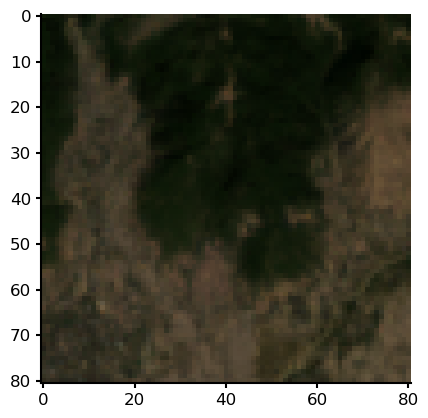

In [20]:
# check image crop fetching function and display crop
from mosaiks.fetch import fetch_image_crop, display_image

row = points_gdf_with_stac.iloc[0]

image_crop = fetch_image_crop(
    lon=row["Lon"],
    lat=row["Lat"],
    stac_item=row["stac_item"],
    buffer=satellite_config["buffer_distance"],
    bands=satellite_config["bands"],
    resolution=satellite_config["resolution"],
    dtype=satellite_config["dtype"],
    normalise=True,
)

display_image(image_crop)

In [21]:
data_loader = create_data_loader(
    points_gdf_with_stac=points_gdf_with_stac,
    satellite_params=satellite_config,
    batch_size=featurization_config["model"]["batch_size"],
)

In [22]:
X_features = create_features(
    dataloader=data_loader,
    n_features=featurization_config["model"]["num_features"],
    model=model,
    device=featurization_config["model"]["device"],
    min_image_edge=satellite_config["min_image_edge"],
)

In [23]:
result_df = make_result_df(
    features=X_features,
    mosaiks_col_names=mosaiks_col_names,
    context_gdf=points_gdf_with_stac,
    context_cols_to_keep=featurization_config["context_cols_to_keep"],
)
result_df

,shrid,Lat,Lon,stac_id,mosaiks_0,mosaiks_1,mosaiks_2,mosaiks_3,mosaiks_4,mosaiks_5,...,mosaiks_3990,mosaiks_3991,mosaiks_3992,mosaiks_3993,mosaiks_3994,mosaiks_3995,mosaiks_3996,mosaiks_3997,mosaiks_3998,mosaiks_3999
319819,11-01-000016,34.554878,74.434486,"[LC08_L2SP_149036_20131212_02_T1, LC08_L2SP_14...",0.000002,1.228295,0.0,0.0,2.045033,0.000833,...,4.880256,0.000862,2.894015,0.000419,6.030777,1.756407,0.029484,2.865542,3.248335,0.003417


In [25]:
utl.save_dataframe(
    df=result_df, file_path=test_mosaiks_folder_path / "TEST_components_df.csv"
)

## Test post-featurization image fetching (for debugging)

In [26]:
# choose featurised data
# data = utl.load_dataframe(test_mosaiks_folder_path / "df_000.parquet.gzip")
data = result_df

In [27]:
# choose row
row = data.iloc[0]
row

shrid                                                11-01-000016
Lat                                                     34.554878
Lon                                                     74.434486
stac_id         [LC08_L2SP_149036_20131212_02_T1, LC08_L2SP_14...
mosaiks_0                                                0.000002
                                      ...                        
mosaiks_3995                                             1.756407
mosaiks_3996                                             0.029484
mosaiks_3997                                             2.865542
mosaiks_3998                                             3.248335
mosaiks_3999                                             0.003417
Name: 319819, Length: 4004, dtype: object

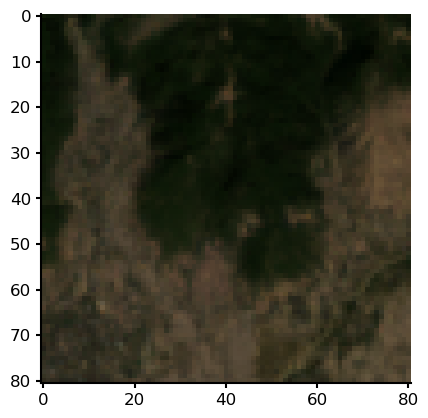

In [28]:
# fetch image crop as per parameters in satellite_config (buffer, bands, etc)
from mosaiks.fetch.images import fetch_image_crop_from_stac_id

image_crop = fetch_image_crop_from_stac_id(
    stac_id=row["stac_id"],
    lon=row["Lon"],
    lat=row["Lat"],
    satellite_config=satellite_config,
    normalise=True,
    plot=True,
)

In [29]:
# # for multiple images (show individual images as opposed to mosaic) ######
# for stac_id in row["stac_id"]:
#     image_crop = fetch_image_crop_from_stac_id(
#         lon=row["Lon"],
#         lat=row["Lat"],
#         stac_id=stac_id,
#         satellite_config=satellite_config,
#         normalise=True,
#         plot=True,
#     )

# Dask runs

In [30]:
### Connect to LOCAL CLIENT
from mosaiks.dask import get_local_dask_client
client = get_local_dask_client(
    featurization_config["dask"]["n_workers"],
    featurization_config["dask"]["threads_per_worker"],
)

INFO:root:/user/amir.emami@idinsight.org/proxy/8787/status


In [31]:
### or connect to GATEWAY
# from mosaiks.dask import get_gateway_cluster_client
# cluster, client = get_gateway_cluster_client()
# cluster

In [32]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/amir.emami@idinsight.org/proxy/8787/status,
Dashboard: /user/amir.emami@idinsight.org/proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33255,Workers: 4
Dashboard: /user/amir.emami@idinsight.org/proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:38153,Total threads: 4
Dashboard: /user/amir.emami@idinsight.org/proxy/43945/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:42989,


In [33]:
mosaiks_folder_path = Path("test_outputs") #utl.make_output_folder_path(featurization_config)
os.makedirs(mosaiks_folder_path, exist_ok=True)

## Method 1 (Preferred) - Queued Futures

In [34]:
from mosaiks.dask import run_queued_futures_pipeline

In [35]:
# %%time

# note that stopping this cell does not stop the dask cluster processing what
# is currently submitted. Use client.restart().
run_queued_futures_pipeline(
    test_points_gdf,
    client=client,
    model=model,
    featurization_config=featurization_config,
    satellite_config=satellite_config,
    col_names=mosaiks_col_names,
    save_folder_path=mosaiks_folder_path,
)

INFO:root:23-May 11:15:40 Trying to kick off initial 8 partitions...
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask_geopandas/hilbert_distance.py:110: RuntimeWarning: divide by zero encountered in double_scalars
  res = (vals - val_range[0]) * (n / width)
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask_geopandas/hilbert_distance.py:110: RuntimeWarning: invalid value encountered in multiply
  res = (vals - val_range[0]) * (n / width)
INFO:root:Distributing 1 points across 500-point partitions results in 1 partitions.
INFO:root:There are less partitions than processors. All 1 partitions running.
/srv/conda/envs/notebook/lib/python3.10/site-packages/stackstac/prepare.py:363: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(
INFO:ro

## Method 2 - Batched Delayed

In [36]:
from mosaiks.dask import run_batched_delayed_pipeline

In [37]:
%%time

# note that stopping this cell does not stop the dask cluster processing what
# is currently submitted. Use client.restart().
run_batched_delayed_pipeline(
    test_points_gdf,
    client=client,
    model=model,
    featurization_config=featurization_config,
    satellite_config=satellite_config,
    col_names=mosaiks_col_names,
    save_folder_path=mosaiks_folder_path,
)

/srv/conda/envs/notebook/lib/python3.10/site-packages/dask_geopandas/hilbert_distance.py:110: RuntimeWarning: divide by zero encountered in double_scalars
  res = (vals - val_range[0]) * (n / width)
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask_geopandas/hilbert_distance.py:110: RuntimeWarning: invalid value encountered in multiply
  res = (vals - val_range[0]) * (n / width)
INFO:root:Distributing 1 points across 500-point partitions results in 1 partitions.
INFO:root:n_partitions is smaller than n_concurrent. Running all 1 partitions.
INFO:root:23-May 11:16:01 Running batch: 0 to 0
/srv/conda/envs/notebook/lib/python3.10/site-packages/stackstac/prepare.py:363: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


CPU times: user 989 ms, sys: 140 ms, total: 1.13 s
Wall time: 5.04 s


[]

## Method 3 - Unbatched Delayed

In [38]:
from mosaiks.dask import delayed_pipeline, run_unbatched_delayed_pipeline

### Single task

In [39]:
delayed_task = delayed_pipeline(
    test_points_gdf,
    model,
    featurization_config,
    satellite_config,
    mosaiks_col_names,
    test_mosaiks_folder_path,
    "TEST_dask_delayed.csv",
)

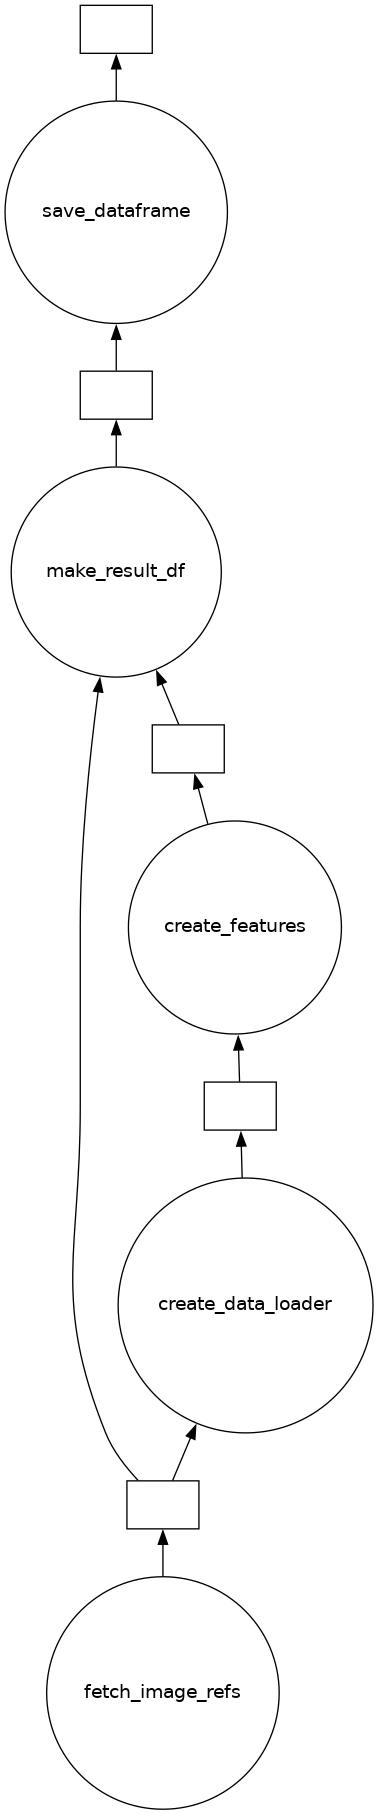

In [40]:
delayed_task.visualize(filename=f"{test_mosaiks_folder_path}/TEST_dask_graph.png")

In [41]:
delayed_task.compute()

/srv/conda/envs/notebook/lib/python3.10/site-packages/stackstac/prepare.py:363: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


### Full run

In [42]:
delayed_task_list = run_unbatched_delayed_pipeline(
    points_gdf=test_points_gdf,
    client=client,
    model=model,
    featurization_config=featurization_config,
    satellite_config=satellite_config,
    col_names=mosaiks_col_names,
    save_folder_path=mosaiks_folder_path,
)

/srv/conda/envs/notebook/lib/python3.10/site-packages/dask_geopandas/hilbert_distance.py:110: RuntimeWarning: divide by zero encountered in double_scalars
  res = (vals - val_range[0]) * (n / width)
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask_geopandas/hilbert_distance.py:110: RuntimeWarning: invalid value encountered in multiply
  res = (vals - val_range[0]) * (n / width)
INFO:root:Distributing 1 points across 500-point partitions results in 1 partitions.
/srv/conda/envs/notebook/lib/python3.10/site-packages/stackstac/prepare.py:363: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


# Load checkpoint files and combine

In [43]:
# # simple test
# data = utl.load_dataframe(mosaiks_folder_path / "df_000.parquet.gzip")
# data

In [44]:
checkpoint_filenames = utl.get_filtered_filenames(
    folder_path=mosaiks_folder_path, prefix="df_"
)
combined_df = utl.load_and_combine_dataframes(
    folder_path=mosaiks_folder_path, filenames=checkpoint_filenames
)
print(f"Dataset size in memory (MB): {combined_df.memory_usage().sum() / 1000000}")

Dataset size in memory (MB): 0.03204


In [45]:
combined_filepath = mosaiks_folder_path / "combined_features.parquet.gzip"
utl.save_dataframe(df=combined_df, file_path=combined_filepath)